In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


## Let's test TPOT AutoML on our UK dataset now

We had our best results here for our Dublin data, but had very poor results on our Cork data. This will give us a better idea of how better suited our model is to larger cities potentially.

In [2]:
irl =  pd.read_csv('leefourfeatures.csv', index_col = 'Unnamed: 0')

In [3]:
irl.shape

(40943, 23)

In [4]:
irl.drop(columns = ['Transaction unique identifier', 'Town/City', 'Add1', 'HouseNum', 'geocode'], inplace = True)

In [5]:
irl = irl.dropna()

In [6]:
irl.shape

(40925, 18)

In [7]:
dt = list(irl['Postcode'])
ps = []
for i in range(len(dt)):
    strg = dt[i][:4]
    ps.append(strg)

In [8]:
irl['Postcode'] = ps

In [9]:
irl.head()

,Price,Postcode,Property Type,Old/New,Duration,Add2,Add3,District,County,PPDCategory Type,Month,Year,Latitude,Longitude,PrimaryDistance,SecondaryDistance,CityCenterDist,ClosestPitch
0,210000,LS25,D,N,F,BOND INGS RISE,SHERBURN IN ELMET,SELBY,NORTH YORKSHIRE,A,5,2017,53.79569,-1.24147,5.687375,9.790351,19.867540,7.816178
1,180000,LS25,D,N,F,RUDSTONE GROVE,SHERBURN IN ELMET,SELBY,NORTH YORKSHIRE,A,4,2017,53.79803,-1.25588,4.756776,8.873555,18.921777,6.864786
2,142500,LS19,F,Y,L,DYEHOUSE WALK,YEADON,LEEDS,WEST YORKSHIRE,A,12,2017,53.85906,-1.68457,0.419900,0.252955,11.584182,0.514805
3,102000,LS18,F,N,L,SUSSEX AVENUE,HORSFORTH,LEEDS,WEST YORKSHIRE,A,12,2017,53.84793,-1.63152,0.666159,0.892213,8.140415,0.287203
4,250000,LS19,S,Y,F,WEAVERS BECK WAY,YEADON,LEEDS,WEST YORKSHIRE,A,9,2017,53.85909,-1.68380,0.419576,0.237613,11.545989,0.537182


In [10]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [11]:
encoder = TargetEncoder()
irl['Add3'] = encoder.fit_transform(irl['Add3'], irl['Price'])

In [12]:
encoder = TargetEncoder()
irl['District'] = encoder.fit_transform(irl['District'], irl['Price'])

In [13]:
encoder = TargetEncoder()
irl['County'] = encoder.fit_transform(irl['County'], irl['Price'])

In [14]:
encoder = TargetEncoder()
irl['Postcode'] = encoder.fit_transform(irl['Postcode'], irl['Price'])

In [15]:
encoder = TargetEncoder()
irl['Add2'] = encoder.fit_transform(irl['Add2'], irl['Price'])

In [16]:
#categorical data
categorical_cols = ['Property Type', 'Old/New', 'Duration', 'PPDCategory Type'] 

#import pandas as pd
df = pd.get_dummies(irl, columns = categorical_cols)

In [17]:
df.columns

Index(['Price', 'Postcode', 'Add2', 'Add3', 'District', 'County', 'Month',
       'Year', 'Latitude', 'Longitude', 'PrimaryDistance', 'SecondaryDistance',
       'CityCenterDist', 'ClosestPitch', 'Property Type_D', 'Property Type_F',
       'Property Type_O', 'Property Type_S', 'Property Type_T', 'Old/New_N',
       'Old/New_Y', 'Duration_F', 'Duration_L', 'PPDCategory Type_A',
       'PPDCategory Type_B'],
      dtype='object')

In [18]:
irl = df

In [19]:
irl.head()

,Price,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,...,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B
0,210000,217630.968385,258739.196082,224647.939686,235254.601253,256030.890142,5,2017,53.79569,-1.24147,...,0,0,0,0,1,0,1,0,1,0
1,180000,217630.968385,205494.667996,224647.939686,235254.601253,256030.890142,4,2017,53.79803,-1.25588,...,0,0,0,0,1,0,1,0,1,0
2,142500,230484.114908,243485.169492,202537.379451,230202.181727,230200.817112,12,2017,53.85906,-1.68457,...,1,0,0,0,0,1,0,1,1,0
3,102000,278963.485067,186296.875000,278963.485067,230202.181727,230200.817112,12,2017,53.84793,-1.63152,...,1,0,0,0,1,0,0,1,1,0
4,250000,230484.114908,254714.655953,202537.379451,230202.181727,230200.817112,9,2017,53.85909,-1.68380,...,0,0,1,0,0,1,1,0,1,0


In [20]:
irl['LogPrice (€)'] = np.log(irl['Price'])
irl.drop(columns = ['Price'], inplace = True)
irl.head()

,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,PrimaryDistance,...,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,LogPrice (€)
0,217630.968385,258739.196082,224647.939686,235254.601253,256030.890142,5,2017,53.79569,-1.24147,5.687375,...,0,0,0,1,0,1,0,1,0,12.254863
1,217630.968385,205494.667996,224647.939686,235254.601253,256030.890142,4,2017,53.79803,-1.25588,4.756776,...,0,0,0,1,0,1,0,1,0,12.100712
2,230484.114908,243485.169492,202537.379451,230202.181727,230200.817112,12,2017,53.85906,-1.68457,0.419900,...,0,0,0,0,1,0,1,1,0,11.867097
3,278963.485067,186296.875000,278963.485067,230202.181727,230200.817112,12,2017,53.84793,-1.63152,0.666159,...,0,0,0,1,0,0,1,1,0,11.532728
4,230484.114908,254714.655953,202537.379451,230202.181727,230200.817112,9,2017,53.85909,-1.68380,0.419576,...,0,1,0,0,1,1,0,1,0,12.429216


In [21]:
from tpot import TPOTRegressor
from sklearn.model_selection import RepeatedKFold

## 2021

### TPOT

In [22]:
specific21 = irl[irl['Year'] > 2017]

In [23]:
train_21 = specific21[specific21['Year'] < 2021]

In [24]:
test_21 = specific21[specific21['Year'] == 2021]

In [25]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [26]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [27]:
x_t_21 = x_test_21

In [28]:
#cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define search
model = TPOTRegressor(max_time_mins = 10)
model1 = model.fit(x_train_21, y_train_21)

In [29]:
#model1.export('tpot_2021_pipeline.py')

In [30]:
# calculated values
from sklearn.metrics import mean_squared_error
y_predicted_21 = model1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_predicted_21))
print('MSE for TPOT AutoML 2021 is: ' + str(mse))

MSE for TPOT AutoML 2021 is: 12550972995.6214


In [31]:
rmse = mean_squared_error(np.exp(y_test_21), np.exp(y_predicted_21), squared=False)
print('RMSE for TPOT AutoML 2021 is: ' + str(rmse))

RMSE for TPOT AutoML 2021 is: 112031.12511985855


In [32]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_predicted_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

31508.925861855812


In [33]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_predicted_21))
print("MAPE for TPOT AutoML 2021 is: " + str(mape))

MAPE for TPOT AutoML 2021 is: 0.3133742821877692


In [34]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy for UK 2021 is: ' + str(acc))

Accuracy for UK 2021 is: 0.3565593464680442


In [126]:
%%capture
import shap
explainer = shap.Explainer(model1.predict, x_test_21)
shap_values = explainer(x_test_21)

In [127]:
vals = np.abs(shap_values.values).mean(0)
feature_names = x_test_21.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance.head()

,col_name,feature_importance_vals
1,Add2,0.167144
13,Property Type_D,0.147488
2,Add3,0.056439
7,Latitude,0.038236
16,Property Type_S,0.034868


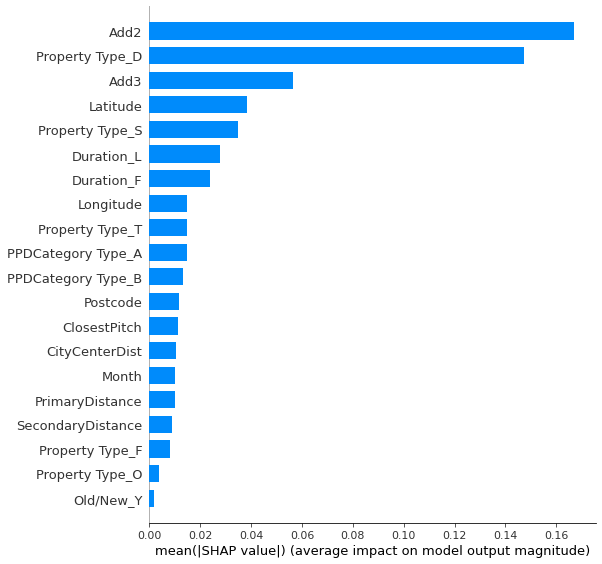

In [128]:
#f = plt.figure()
shap.summary_plot(shap_values, x_test_21, plot_type = 'bar')
#f.savefig("summary_plotleeds21.png", bbox_inches = 'tight', dpi = 600)

In [37]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'TPOT AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [38]:
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020

In [39]:
specific20 = irl[irl['Year'] > 2016]

In [40]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [41]:
x_t_20 = x_test_20

In [42]:
model = TPOTRegressor(max_time_mins = 10)
model2 = model.fit(x_train_20, y_train_20)

In [43]:
#model2.export('tpot_2020_pipeline.py')

In [44]:
y_predicted_20 = model2.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_predicted_20))
print('MSE for TPOT AutoML 2020 is: ' + str(mse))

MSE for TPOT AutoML 2020 is: 5242057962.397977


In [45]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_predicted_20))
print("MAPE for TPOT AutoML 2020 is: " + str(mape))

MAPE for TPOT AutoML 2020 is: 0.10428186767382644


In [46]:
median_se = np.square(np.subtract(np.exp(y_test_20), np.exp(y_predicted_20))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

13154.338355913816


In [47]:
rmse = mean_squared_error(np.exp(y_test_20), np.exp(y_predicted_20), squared=False)
print('RMSE for TPOT AutoML 2020 is: ' + str(rmse))

RMSE for TPOT AutoML 2020 is: 72402.05772212539


In [48]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy for UK 2020 is: ' + str(acc))

Accuracy for UK 2020 is: 0.6693607641440118


In [49]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns=cnames)

df12 = df12.append({'Algorithm': 'TPOT AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [50]:
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)

In [129]:
%%capture
explainer = shap.Explainer(model2.predict, x_test_20)
shap_values2 = explainer(x_test_20)

In [130]:
vals1 = np.abs(shap_values2.values).mean(0)
feature_names1 = x_test_20.columns

feature_importance1 = pd.DataFrame(list(zip(feature_names1, vals1)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance1.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance1.head()

,col_name,feature_importance_vals
13,Property Type_D,0.132026
1,Add2,0.069607
2,Add3,0.050220
20,Duration_F,0.049255
21,Duration_L,0.042201


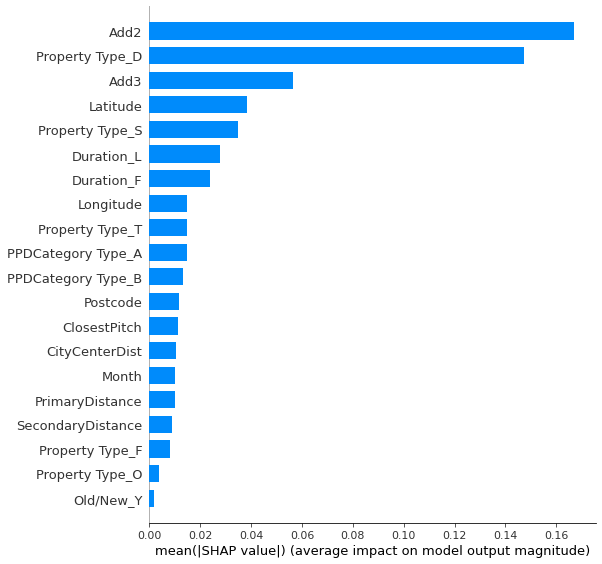

In [131]:
#f = plt.figure()
shap.summary_plot(shap_values2, x_test_20, plot_type = 'bar')
#f.savefig("summary_plotleeds20.png", bbox_inches = 'tight', dpi = 600)

### 2019

In [53]:
specific19 = irl[irl['Year'] > 2015]

In [54]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

In [55]:
x_t_19 = x_test_19

In [56]:
model = TPOTRegressor(max_time_mins = 10)
# perform the search // takes ages to run!
model3 = model.fit(x_train_19, y_train_19)

In [57]:
#model3.export('tpot_2019_pipeline.py')

In [58]:
y_predicted_19 = model3.predict(x_test_19)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_predicted_19))
print('MSE for TPOT AutoML 2019 is: ' + str(mse))

MSE for TPOT AutoML 2019 is: 3497194052.657651


In [59]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_predicted_19))
print("MAPE for TPOT AutoML 2019 is: " + str(mape))

MAPE for TPOT AutoML 2019 is: 0.1194245297883696


In [60]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_predicted_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

12417.706613619546


In [61]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_predicted_19), squared = False)
print('RMSE for TPOT AutoML 2019 is: ' + str(rmse))

RMSE for TPOT AutoML 2019 is: 59137.0784927498


In [62]:
acc = accuracy_threshold(y_test_19, y_predicted_19, 0.1)
print('Accuracy for UK 2019 is: ' + str(acc))

Accuracy for UK 2019 is: 0.668485102811582


In [136]:
%%capture
explainer = shap.Explainer(model3.predict, x_test_19)
shap_values3 = explainer(x_test_19)

In [137]:
vals2 = np.abs(shap_values3.values).mean(0)
feature_names2 = x_test_19.columns

feature_importance2 = pd.DataFrame(list(zip(feature_names2, vals2)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance2.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance2.head()

,col_name,feature_importance_vals
1,Add2,0.159034
13,Property Type_D,0.158853
2,Add3,0.052641
7,Latitude,0.035151
16,Property Type_S,0.028543


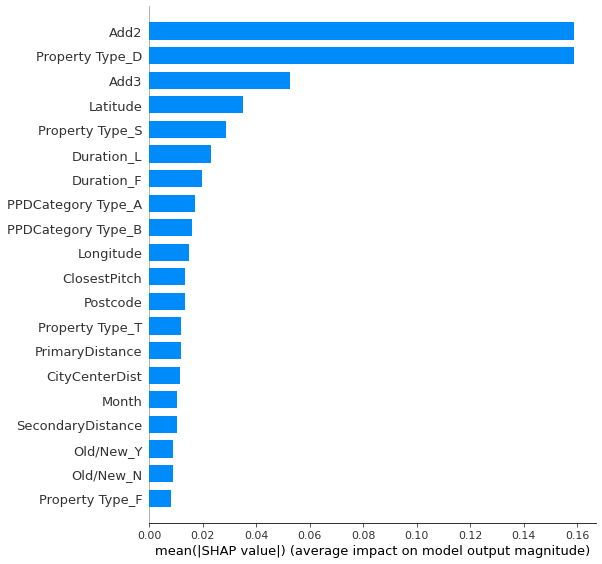

In [138]:
#f = plt.figure()
shap.summary_plot(shap_values3, x_test_19, plot_type = 'bar')
#f.savefig("summary_plotleeds19.png", bbox_inches = 'tight', dpi = 600)

In [65]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'TPOT AutoML',
            'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [66]:
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_predicted_19)

### 2018

In [67]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

In [68]:
x_t_18 = x_test_18

In [69]:
model = TPOTRegressor(max_time_mins = 10)
# perform the search // takes ages to run!
model4 = model.fit(x_train_18, y_train_18)

In [70]:
#model4.export('tpot_2018_pipeline.py')

In [71]:
y_predicted_18 = model4.predict(x_test_18)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_predicted_18))
print('MSE for TPOT AutoML 2018 is: ' + str(mse))

MSE for TPOT AutoML 2018 is: 1424027944.5195136


In [72]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_predicted_18), squared = False)
print('RMSE for TPOT AutoML 2018 is: ' + str(rmse))

RMSE for TPOT AutoML 2018 is: 37736.29479055295


In [73]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_predicted_18))
print("MAPE for TPOT AutoML 2018 is: " + str(mape))

MAPE for TPOT AutoML 2018 is: 0.07916306564106394


In [74]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_predicted_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

7321.837972360836


In [75]:
acc = accuracy_threshold(y_test_18, y_predicted_18, 0.1)
print('Accuracy for UK 2018 is: ' + str(acc))

Accuracy for UK 2018 is: 0.8174936921783011


In [139]:
%%capture
explainer = shap.Explainer(model4.predict, x_test_18)
shap_values4 = explainer(x_test_18)

In [140]:
vals3 = np.abs(shap_values4.values).mean(0)
feature_names3 = x_test_18.columns

feature_importance3 = pd.DataFrame(list(zip(feature_names3, vals3)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance3.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance3.head()

,col_name,feature_importance_vals
1,Add2,0.185722
13,Property Type_D,0.147058
2,Add3,0.049532
7,Latitude,0.032930
16,Property Type_S,0.030430


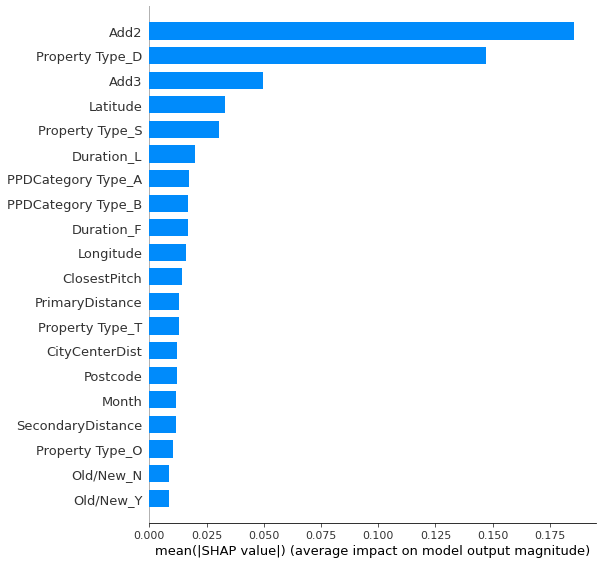

In [141]:
#f = plt.figure()
shap.summary_plot(shap_values4, x_test_18, plot_type = 'bar')
#f.savefig("summary_plotleeds18.png", bbox_inches = 'tight', dpi = 600)

In [78]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns=cnames)

df14 = df14.append({'Algorithm': 'TPOT AutoML',
            'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [79]:
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_predicted_18)

### 2017

In [80]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [81]:
x_t_17 = x_test_17

In [82]:
model = TPOTRegressor(max_time_mins = 10)
# perform the search // takes ages to run!
model5 = model.fit(x_train_17, y_train_17)

In [83]:
#model5.export('tpot_2017_pipeline.py')

In [84]:
y_predicted_17 = model5.predict(x_test_17)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_predicted_17))
print('MSE for TPOT AutoML 2017 is: ' + str(mse))

MSE for TPOT AutoML 2017 is: 11761202069.412249


In [85]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_predicted_17))
print("MAPE for TPOT AutoML 2017 is: " + str(mape))

MAPE for TPOT AutoML 2017 is: 0.21836392829700815


In [86]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_predicted_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

23542.203512263135


In [87]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_predicted_17), squared=False)
print('RMSE for TPOT AutoML 2017 is: ' + str(rmse))

RMSE for TPOT AutoML 2017 is: 108449.07592696328


In [88]:
acc = accuracy_threshold(y_test_17, y_predicted_17, 0.1)
print('Accuracy for UK 2017 is: ' + str(acc))

Accuracy for UK 2017 is: 0.42383970558168066


In [142]:
%%capture
explainer = shap.Explainer(model1.predict, x_test_17)
shap_values = explainer(x_test_17)

In [144]:
vals4 = np.abs(shap_values.values).mean(0)
feature_names4 = x_test_17.columns

feature_importance4 = pd.DataFrame(list(zip(feature_names4, vals4)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance4.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance4.head()

,col_name,feature_importance_vals
1,Add2,0.187870
13,Property Type_D,0.139526
2,Add3,0.049870
7,Latitude,0.032341
16,Property Type_S,0.026573


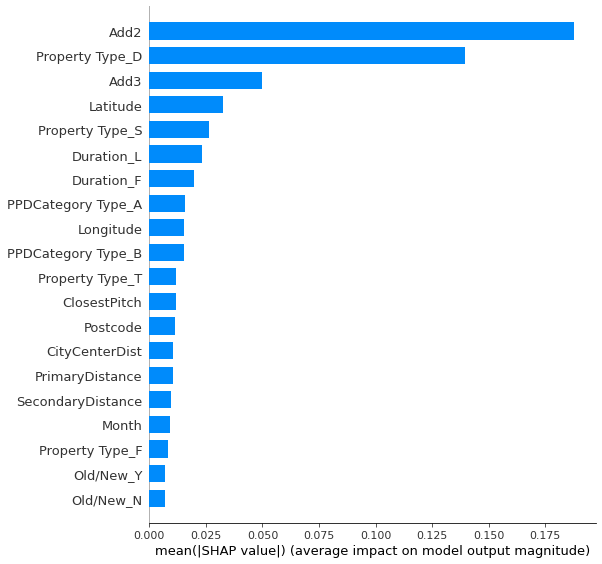

In [146]:
#f = plt.figure()
shap.summary_plot(shap_values, x_test_17, plot_type = 'bar')
#f.savefig("summary_plotleeds17.png", bbox_inches = 'tight', dpi = 600)

In [91]:
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_predicted_17)

In [92]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns=cnames)

df15 = df15.append({'Algorithm': 'TPOT AutoML',
            'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [93]:
vis1 = pd.concat([df11, df12, df13, df14, df15], ignore_index=True)

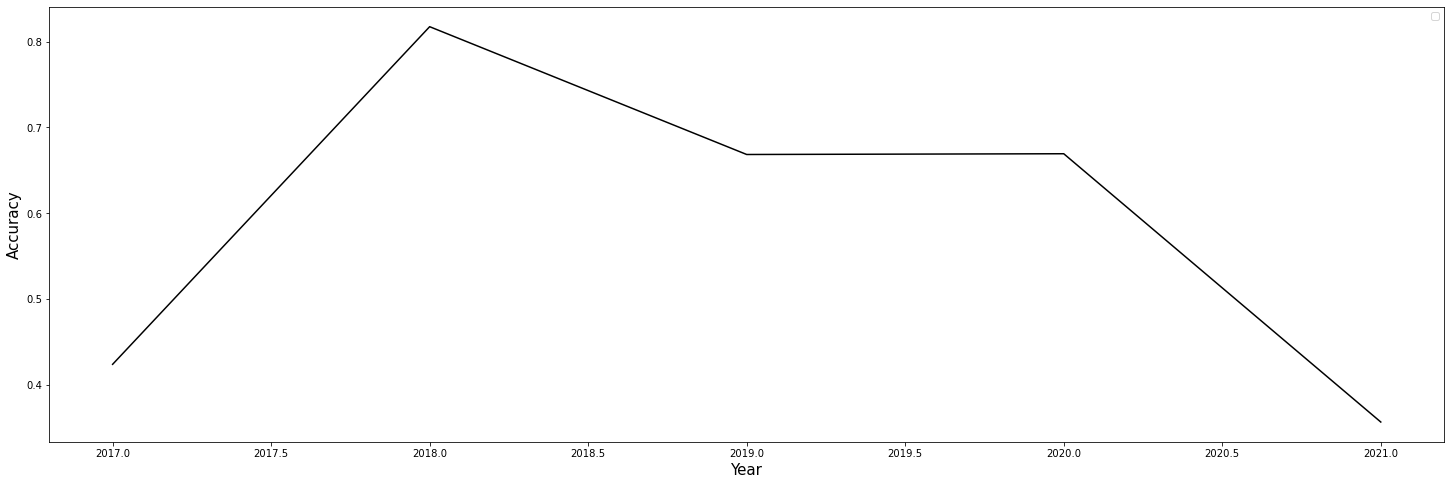

In [94]:
# don't need cross validation same training due to set intervals?
fig, ax = plt.subplots(figsize = (25, 8))
plt.plot(vis1['Year'], vis1['Accuracy'], color = 'black')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
#plt.title('TPOT AutoML Results 2017 - 2021')
plt.legend()
plt.show()

#fig.savefig('performance-overtime-leedstpot.png', bbox_inches='tight')

In [95]:
print("Mean accuracy for TPOT AutoML over period 2017-2021 is: " + str(vis1['Accuracy'].mean()))
# Mean accuracy for TPOT AutoML over period 2017-2021 is: 0.5239357019141636

Mean accuracy for TPOT AutoML over period 2017-2021 is: 0.587147722236724


In [96]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index = True)
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,12.823148
1,11.891362
2,13.681979
3,11.982929
4,11.652687


In [97]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index = True)
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,12.756890
1,11.663571
2,13.217685
3,12.360918
4,11.627618


In [98]:
actualvpred = actual.join(pred)

In [99]:
actualvpred.head()

,Actual,Predicted
0,12.823148,12.756890
1,11.891362,11.663571
2,13.681979,13.217685
3,11.982929,12.360918
4,11.652687,11.627618


In [100]:
exp = np.exp(actualvpred)

In [101]:
exp.shape

(27414, 2)

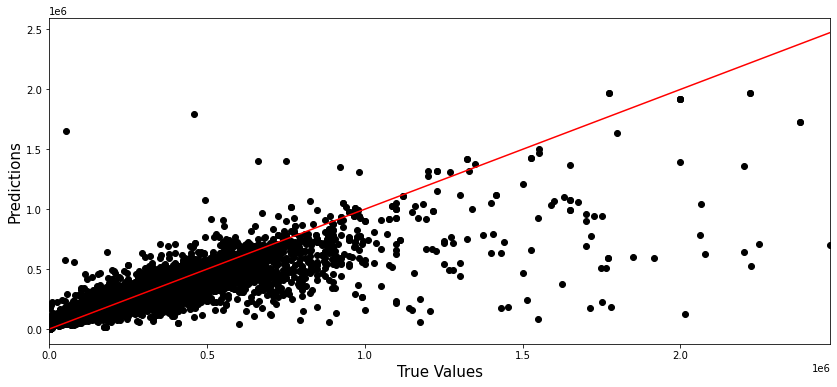

In [125]:
# plot predicted vs actual
## this is using actual prices hence adjusted scale compared to mljar plot
fig, ax = plt.subplots(figsize = (14, 6))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'black')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
#plt.title('TPOT AutoML Actual Vs Predicted Values')
plt.xlim([0, max(exp['Actual'])])
#plt.axis('equal')
plt.show()

fig.savefig('actualvpred-leedstpot3.png', bbox_inches='tight')

In [103]:
x_t_21 = x_t_21.reset_index()
x_t_20 = x_t_20.reset_index()
x_t_19 = x_t_19.reset_index()
x_t_18 = x_t_18.reset_index()
x_t_17 = x_t_17.reset_index()

x_t_21.drop(columns = ['index'], inplace = True)
x_t_20.drop(columns = ['index'], inplace = True)
x_t_19.drop(columns = ['index'], inplace = True)
x_t_18.drop(columns = ['index'], inplace = True)
x_t_17.drop(columns = ['index'], inplace = True)

In [104]:
l1 = dfreal1.join(x_t_21[['Longitude', 'Latitude']])
l2 = dfreal2.join(x_t_20[['Longitude', 'Latitude']])
l3 = dfreal3.join(x_t_19[['Longitude', 'Latitude']])
l4 = dfreal4.join(x_t_18[['Longitude', 'Latitude']])
l5 = dfreal5.join(x_t_17[['Longitude', 'Latitude']])

plots = pd.concat([l1, l2, l3, l4, l5], ignore_index=True)
plots.head()

,0,Longitude,Latitude
0,12.823148,-1.58847,53.74855
1,11.891362,-1.61968,53.80770
2,13.681979,-1.65612,53.83972
3,11.982929,-1.47258,53.85191
4,11.652687,-1.44393,53.72532


In [105]:
plots.rename(columns = {0 : 'Actual'}, inplace = True)

In [106]:
plots.head()

,Actual,Longitude,Latitude
0,12.823148,-1.58847,53.74855
1,11.891362,-1.61968,53.80770
2,13.681979,-1.65612,53.83972
3,11.982929,-1.47258,53.85191
4,11.652687,-1.44393,53.72532


In [107]:
plotscomp = plots.join(pred)
plotscomp.head()

,Actual,Longitude,Latitude,Predicted
0,12.823148,-1.58847,53.74855,12.756890
1,11.891362,-1.61968,53.80770,11.663571
2,13.681979,-1.65612,53.83972,13.217685
3,11.982929,-1.47258,53.85191,12.360918
4,11.652687,-1.44393,53.72532,11.627618


In [108]:
exp1 = np.exp(plotscomp[['Actual', 'Predicted']])

In [109]:
exp1 = exp1.join(plotscomp[['Longitude', 'Latitude']])

In [110]:
exp1.head()

,Actual,Predicted,Longitude,Latitude
0,370700.0,346934.042800,-1.58847,53.74855
1,146000.0,116258.496070,-1.61968,53.80770
2,875000.0,550006.321218,-1.65612,53.83972
3,160000.0,233495.414651,-1.47258,53.85191
4,115000.0,112152.885011,-1.44393,53.72532


In [111]:
vis1

,Algorithm,Year,RMSE,MSE,MEDAE,Accuracy,MAPE
0,TPOT AutoML,2021,112031.125120,1.255097e+10,31508.925862,0.356559,0.313374
1,TPOT AutoML,2020,72402.057722,5.242058e+09,13154.338356,0.669361,0.104282
2,TPOT AutoML,2019,59137.078493,3.497194e+09,12417.706614,0.668485,0.119425
3,TPOT AutoML,2018,37736.294791,1.424028e+09,7321.837972,0.817494,0.079163
4,TPOT AutoML,2017,108449.075927,1.176120e+10,23542.203512,0.423840,0.218364


In [112]:
valuess = pd.DataFrame(vis1[['RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']].mean())
valuess.rename(columns={0: 'Averages'}, inplace = True)
valuess.style.format("{:.3f}")

,Averages
RMSE,77951.126
MSE,6895091004.922
MEDAE,17589.002
Accuracy,0.587
MAPE,0.167


In [147]:
s1 = pd.merge(feature_importance, feature_importance1, on = 'col_name', how='inner')
s2 = pd.merge(s1, feature_importance2, on = 'col_name', how='inner')
s3 = pd.merge(s2, feature_importance3, on = 'col_name', how='inner')
s4 = pd.merge(s3, feature_importance4, on = 'col_name', how='inner')
s4

Passing 'suffixes' which cause duplicate columns {'feature_importance_vals_x'} in the result is deprecated and will raise a MergeError in a future version.


,col_name,feature_importance_vals_x,feature_importance_vals_y,feature_importance_vals_x,feature_importance_vals_y,feature_importance_vals
0,Add2,0.167144,0.069607,0.159034,0.185722,0.187870
1,Property Type_D,0.147488,0.132026,0.158853,0.147058,0.139526
2,Add3,0.056439,0.050220,0.052641,0.049532,0.049870
3,Latitude,0.038236,0.042038,0.035151,0.032930,0.032341
4,Property Type_S,0.034868,0.014133,0.028543,0.030430,0.026573
5,Duration_L,0.027636,0.042201,0.022894,0.019754,0.023328
6,Duration_F,0.023954,0.049255,0.019778,0.016729,0.019946
7,Longitude,0.014876,0.021938,0.015027,0.015878,0.015470
8,Property Type_T,0.014793,0.040664,0.011789,0.013059,0.011985
9,PPDCategory Type_A,0.014704,0.024718,0.017032,0.017432,0.015731


In [148]:
s4.columns = ['col_name', '1', '2', '3', '4', '5']
s4

,col_name,1,2,3,4,5
0,Add2,0.167144,0.069607,0.159034,0.185722,0.187870
1,Property Type_D,0.147488,0.132026,0.158853,0.147058,0.139526
2,Add3,0.056439,0.050220,0.052641,0.049532,0.049870
3,Latitude,0.038236,0.042038,0.035151,0.032930,0.032341
4,Property Type_S,0.034868,0.014133,0.028543,0.030430,0.026573
5,Duration_L,0.027636,0.042201,0.022894,0.019754,0.023328
6,Duration_F,0.023954,0.049255,0.019778,0.016729,0.019946
7,Longitude,0.014876,0.021938,0.015027,0.015878,0.015470
8,Property Type_T,0.014793,0.040664,0.011789,0.013059,0.011985
9,PPDCategory Type_A,0.014704,0.024718,0.017032,0.017432,0.015731


In [149]:
sum_column = s4["1"] + s4["2"] + s4["3"] + s4["4"] + s4["5"]
s4['sumshap'] = sum_column
s4['avgshap'] = sum_column / 5

In [150]:
s4 = s4.sort_values(by=['avgshap'], ascending = False)

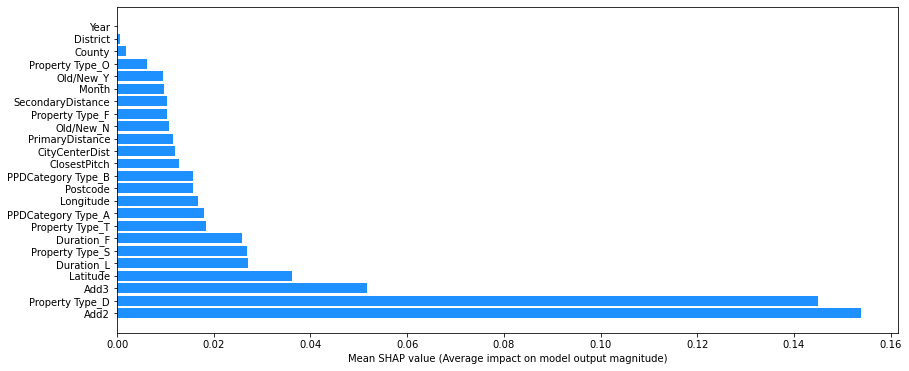

In [151]:
# creating the bar plot
figz = plt.figure(figsize=(14, 6))

plt.barh(s4['col_name'], s4['avgshap'], color = 'dodgerblue')

plt.xlabel("Mean SHAP value (Average impact on model output magnitude)")
figz.savefig('uk-mean-shap.png', bbox_inches = 'tight')
plt.show()